In [127]:
%reload_ext autoreload
%autoreload 2

In [128]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
# from wordcloud import WordCloud

In [129]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

## Extract all the channesl in the slack

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [130]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [131]:
from collections import defaultdict


data_loader = SlackDataLoader("../data")
all_channels = data_loader.get_channels()

reactions = data_loader.parse_slack_reaction("../data/all-week1", "all-week1")
# print(reactions.head())
users_replay_count = {}

for channel in all_channels:
    slack_parsed, channel_user_replay_count = data_loader.slack_parser(f"../data/{channel["name"]}")
    for key, value in channel_user_replay_count.items():
        users_replay_count[key] = users_replay_count.get(key, 0) + value


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

### Top 10 and bottom 10 users by reply count

In [143]:
# which user has the highest number of reply counts?
userNamesById, userIdsByName = data_loader.get_user_map()
sorted_users_replay_count = list(sorted(users_replay_count.items(), key=lambda x:x[1], reverse=True))
print("Top 10 users by replay count: ")
for i in range(10):
    print(f"{1+i}. username: {userNamesById[sorted_users_replay_count[i][0]]}, with replay count: {sorted_users_replay_count[i][1]}")

print()

print("Bottom 10 users by replay count: ")
index = 1
for i in range(len(sorted_users_replay_count)-1, len(sorted_users_replay_count)-11, -1):
    print(f"{index}. username: {userNamesById[sorted_users_replay_count[i][0]]}, with replay count: {sorted_users_replay_count[i][1]}")
    index += 1

Top 10 users by replay count: 
1. username: Travis, with replay count: 191
2. username: Brenda, with replay count: 141
3. username: Vanessa, with replay count: 138
4. username: Amy, with replay count: 133
5. username: Cristian, with replay count: 126
6. username: Phillip, with replay count: 112
7. username: April, with replay count: 110
8. username: Brady, with replay count: 97
9. username: Judith, with replay count: 97
10. username: Joshua, with replay count: 81

Bottom 10 users by replay count: 
1. username: Leah, with replay count: 1
2. username: Randy, with replay count: 1
3. username: David, with replay count: 1
4. username: Patrick, with replay count: 2
5. username: Melissa, with replay count: 3
6. username: Patricia, with replay count: 3
7. username: Vernon, with replay count: 4
8. username: Steven, with replay count: 7
9. username: Samantha, with replay count: 7
10. username: Allison, with replay count: 7


### Top 10 and bottom 10 users by Mention

In [144]:
users_mention_count = {}

for channel in all_channels:
    channel_users_metions_count = utils.get_user_mentions_from_channel(f"../data/{channel["name"]}")
    for key, value in channel_users_metions_count.items():
        users_mention_count[key] = users_mention_count.get(key, 0) + value


In [145]:

sorted_users_mention_count = list(sorted(users_mention_count.items(), key=lambda x:x[1], reverse=True))
print("Top 10 users by mention count: ")
for i in range(10):
    print(f"{1+i}. username: {userNamesById[sorted_users_mention_count[i][0]]}, with mention count: {sorted_users_mention_count[i][1]}")

Top 10 users by mention count: 
1. username: Vanessa, with mention count: 198
2. username: Garrett, with mention count: 186
3. username: Amy, with mention count: 183
4. username: Brittany, with mention count: 178
5. username: April, with mention count: 173
6. username: Travis, with mention count: 172
7. username: Judith, with mention count: 139
8. username: Phillip, with mention count: 136
9. username: Brady, with mention count: 135
10. username: Brian, with mention count: 123


In [146]:
print("Bottom 10 users by mention count: ")
index = 1
for i in range(len(sorted_users_mention_count)-1, len(sorted_users_mention_count)-11, -1):
    print(f"{index}. username: {userNamesById[sorted_users_mention_count[i][0]]}, with mention count: {sorted_users_mention_count[i][1]}")
    index += 1

Bottom 10 users by mention count: 
1. username: Steven, with mention count: 3
2. username: Patricia, with mention count: 4
3. username: Bethany, with mention count: 5
4. username: Patrick, with mention count: 5
5. username: Carol, with mention count: 5
6. username: Randy, with mention count: 6
7. username: Vernon, with mention count: 6
8. username: Leah, with mention count: 8
9. username: Melissa, with mention count: 10
10. username: Dustin, with mention count: 13


### Top 10 and bottom 10 users by Message count

In [147]:
users_messages_count = {}
for channel in all_channels:
    channel_users_messages_count = utils.get_user_mentions_from_channel(f"../data/{channel["name"]}")
    for key, value in channel_users_messages_count.items():
        users_messages_count[key] = users_messages_count.get(key, 0) + value


In [148]:

sorted_users_messages_count = list(sorted(users_messages_count.items(), key=lambda x:x[1], reverse=True))
print("Top 10 users by messages count: ")
for i in range(10):
    print(f"{1+i}. username: {userNamesById[sorted_users_messages_count[i][0]]}, with message count: {sorted_users_messages_count[i][1]}")

Top 10 users by messages count: 
1. username: Vanessa, with message count: 198
2. username: Garrett, with message count: 186
3. username: Amy, with message count: 183
4. username: Brittany, with message count: 178
5. username: April, with message count: 173
6. username: Travis, with message count: 172
7. username: Judith, with message count: 139
8. username: Phillip, with message count: 136
9. username: Brady, with message count: 135
10. username: Brian, with message count: 123


In [155]:
print("Bottom 10 users by messages count: ")
index = 1
for i in range(len(sorted_users_mention_count)-1, len(sorted_users_mention_count)-11, -1):
    print(f"{index}. username: {userNamesById[sorted_users_mention_count[i][0]]}, with message count: {sorted_users_mention_count[i][1]}")
    index += 1

Bottom 10 users by messages count: 
1. username: Steven, with message count: 3
2. username: Patricia, with message count: 4
3. username: Bethany, with message count: 5
4. username: Patrick, with message count: 5
5. username: Carol, with message count: 5
6. username: Randy, with message count: 6
7. username: Vernon, with message count: 6
8. username: Leah, with message count: 8
9. username: Melissa, with message count: 10
10. username: Dustin, with message count: 13


### Top 10 and bottom 10 users by Reaction count

In [153]:
users_reactions_count = {}
for channel in all_channels:
    channel_user_reactions_count = utils.get_user_mentions_from_channel(f"../data/{channel["name"]}")
    for key, value in channel_user_reactions_count.items():
        users_reactions_count[key] = users_reactions_count.get(key, 0) + value


print(users_reactions_count)

{'U03U1GHT39V': 50, 'U03V1AM5TFA': 198, 'U03U9FWPNCE': 51, 'U03UG32J3PC': 173, 'U03UG1Z21JP': 50, 'U03V5Q9N516': 37, 'U03U1FNPEUX': 86, 'U03U1HAG9TR': 92, 'U03UG4Q7V42': 136, 'U03UAKATQ22': 16, 'U03UJGRN5E0': 61, 'U03UHB8CXDY': 22, 'U03V6HMRPGQ': 99, 'U03UG5VFN03': 18, 'U03UVHCV6KB': 172, 'U03UJKJGRAQ': 123, 'U03UD5B7C3X': 31, 'U03V785NLSU': 80, 'U03UJGP0C68': 139, 'U03T89ACUUW': 54, 'U03UL5LSTG9': 43, 'U03UFV7HFNF': 35, 'U03UD4FEDHB': 56, 'U03UH397319': 72, 'U03UKL27B0R': 178, 'U03UJH1EQQL': 24, 'U03UD68RQH3': 135, 'U03UP7V9Q57': 72, 'U03UFV7TUTV': 20, 'U03U9DB7REG': 94, 'U03UG1RTXAP': 5, 'U03U9EJR362': 34, 'U03UUR571A5': 183, 'U03UUMR26Q1': 22, 'U03U4GULU3Y': 46, 'U03TEPYRM2P': 186, 'U03V8LHPDME': 86, 'U03UJN29Y4C': 52, 'U03TT5KEYCF': 43, 'U03UYNR4TS4': 5, 'U03UDBUL7CL': 4, 'U03UUN8M4RX': 70, 'U03UUS0MZCZ': 47, 'U03UG0YHAUT': 26, 'U03UUMM7Y8H': 17, 'U03UUP56MDF': 54, 'U03UG0SFHGT': 34, 'U03U93GNNVB': 61, 'U03UJGFG2HJ': 6, 'U03UG569P7U': 10, 'U03U1J51VFZ': 22, 'U03TX2VN6H5': 30, 'U03V

In [154]:

sorted_users_reactions_count = list(sorted(users_reactions_count.items(), key=lambda x:x[1], reverse=True))
print("Top 10 users by reactions count: ")
for i in range(10):
    print(f"{1+i}. username: {userNamesById[sorted_users_reactions_count[i][0]]}, with reaction count: {sorted_users_reactions_count[i][1]}")

Top 10 users by reactions count: 
1. username: Vanessa, with reaction count: 198
2. username: Garrett, with reaction count: 186
3. username: Amy, with reaction count: 183
4. username: Brittany, with reaction count: 178
5. username: April, with reaction count: 173
6. username: Travis, with reaction count: 172
7. username: Judith, with reaction count: 139
8. username: Phillip, with reaction count: 136
9. username: Brady, with reaction count: 135
10. username: Brian, with reaction count: 123


In [156]:
print("Bottom 10 users by reactions count: ")
index = 1
for i in range(len(sorted_users_reactions_count)-1, len(sorted_users_reactions_count)-11, -1):
    print(f"{index}. username: {userNamesById[sorted_users_reactions_count[i][0]]}, with reaction count: {sorted_users_reactions_count[i][1]}")
    index += 1

Bottom 10 users by reactions count: 
1. username: Steven, with reaction count: 3
2. username: Patricia, with reaction count: 4
3. username: Bethany, with reaction count: 5
4. username: Patrick, with reaction count: 5
5. username: Carol, with reaction count: 5
6. username: Randy, with reaction count: 6
7. username: Vernon, with reaction count: 6
8. username: Leah, with reaction count: 8
9. username: Melissa, with reaction count: 10
10. username: Dustin, with reaction count: 13


### Top 10 message by reply count

In [172]:
list_of_dfs = []
for channel in all_channels:
    df, _ = data_loader.slack_parser(f"../data/{channel["name"]}")
    list_of_dfs.append(df)
    
combined_df = pd.concat(list_of_dfs, ignore_index=True)

# Get the top 10 messages with the highest reply_count
top_10_messages = combined_df.nlargest(10, 'reply_count')
print("Top 10 messages by reply count")
print(top_10_messages[['msg_content', 'reply_count']])


Top 10 messages by reply count
                                             msg_content  reply_count
7215           <@U03V1AM5TFA> how many crushes you have?           75
6460   First Impression: People think I am older than...           63
15234  1. How do I find my jupyter notebook file in m...           61
4454   How many here follow football so much? I think...           57
10061                    Ethiopian New year Loading ....           54
11383  Hello\n1. <@U03UVHCV6KB>\n2. <@U03UG5VFN03>\n3...           45
16512  <@U03UUR571A5> Solutions to funding account an...           44
10529  We had a plan to meet today 2:00 EAT at Friend...           36
11538  *<!here> REMINDER*:timer_clock:\n\n*Please not...           33
2375   the debate was great. We <@U03U1J51VFZ>, <@U03...           31


### Top 10 message by Reaction count

In [184]:
list_of_dfs = []
for channel in all_channels:
    df = data_loader.parse_slack_reaction(f"../data/{channel["name"]}", channel["name"])
    list_of_dfs.append(df)
    

combined_df = pd.concat(list_of_dfs, ignore_index=True)

combined_df['reaction_count'] = pd.to_numeric(combined_df['reaction_count'], errors='coerce')

# Drop rows with NaN in 'reaction_count'
df_reaction_cleaned = combined_df.dropna(subset=['reaction_count'])

# Get the top 10 messages with the highest numeric 'reaction_count'
top_10_messages_with_highest_reaction_count = df_reaction_cleaned.nlargest(10, 'reaction_count')

# Print the result
print(top_10_messages_with_highest_reaction_count[['message', 'reaction_count']])



                                                message  reaction_count
4693  Good morning winners, welcome to week 9 of wee...              17
395                                                                  16
1499  My reactions when am not finished the task bef...              16
4075  Little known fact - all 10 Academy technical t...              16
301   *Here are some other stories from people that ...              15
1881  *Guys <!here>.... Make sure to come back from ...              15
4488  Welcome to week6 everyone. By Friday, we’ll be...              15
1012  1- let me open my VPN, where do you want me to...              14
3358  <!channel>\nThere will be no careers exercise ...              14
795           meat that is even more raw <@U03UUR571A5>              13


### Top 10 message by Mention count

In [183]:
# list_of_dfs = []
# for channel in all_channels:
#     df = data_loader.parse_slack_reaction(f"../data/{channel["name"]}", channel["name"])
#     list_of_dfs.append(df)
count = utils.get_message_mentions_count_from_channel(f"../data/all-week1")

### Messages Count Of Channel Vs Sum of replies and reactions

In [188]:
list_of_dfs = []
x_axis_message_count = {}
y_axis_reply_reaction_count = {}

for channel in all_channels:
    replay_df, _ = data_loader.slack_parser(f"../data/{channel["name"]}")
    reaction_df = data_loader.parse_slack_reaction(f"../data/{channel["name"]}", channel["name"])

    list_of_dfs.append(df)

    total_reply_count = replay_df['reply_count'].sum()
    total_reaction_count = reaction_df['reaction_count'].sum()

    x_axis_message_count[channel["name"]] = len(replay_df)
    y_axis_reply_reaction_count[channel["name"]] = total_reply_count + total_reaction_count


# print(x_axis_message_count, y_axis_reply_reaction_count)



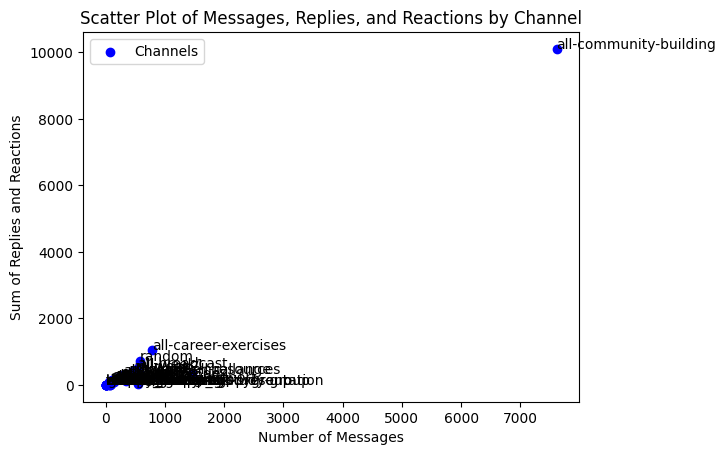

In [193]:
channels = list(x_axis_message_count.keys())
x_values = list(x_axis_message_count.values())
y_values = list(y_axis_reply_reaction_count.values())

# Scatter plot
plt.scatter(x_values, y_values, c='blue', label='Channels')

# Add labels and title
plt.xlabel('Number of Messages')
plt.ylabel('Sum of Replies and Reactions')
plt.title('Scatter Plot of Messages, Replies, and Reactions by Channel')

# Add channel labels
for i, channel in enumerate(channels):
    plt.annotate(channel, (x_values[i], y_values[i]))

# Show legend
plt.legend()

# Show the plot
plt.show()

- all-community-building appear at the top right corner of the graph

In [ ]:
# Visualize reply counts per user per channel

In [ ]:
# what is the time range of the day that most messages are sent?


In [11]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?